In [26]:
import numpy as np

# Example matrix X
X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# Number of repetitions per column
h = 2

# Repeat each column h times
X_repeated = np.repeat(X, h, axis=1)

print("Original Matrix X:")
print(X)

print("\nNew Matrix with Columns Repeated:")
print(X_repeated)


Original Matrix X:
[[1 2 3]
 [4 5 6]
 [7 8 9]]

New Matrix with Columns Repeated:
[[1 1 2 2 3 3]
 [4 4 5 5 6 6]
 [7 7 8 8 9 9]]


In [83]:
import numpy as np
import scipy.io as sio
mout = sio.loadmat('mout.mat')['mout']
m = mout.reshape(500,5)

print(m[:100])

[[3.26767921e-06 3.26767921e-06 3.26767921e-06 3.26767921e-06
  3.26767921e-06]
 [4.55667808e-06 4.55667808e-06 4.55667808e-06 4.55667808e-06
  4.55667808e-06]
 [3.48334278e-06 3.48334278e-06 3.48334278e-06 3.48334278e-06
  3.48334278e-06]
 [2.81611915e-06 2.81611915e-06 2.81611915e-06 2.81611915e-06
  2.81611915e-06]
 [7.00972337e-06 7.00972337e-06 7.00972337e-06 7.00972337e-06
  7.00972337e-06]
 [7.26030353e-06 7.26030353e-06 7.26030353e-06 7.26030353e-06
  7.26030353e-06]
 [3.14076465e-06 3.14076465e-06 3.14076465e-06 3.14076465e-06
  3.14076465e-06]
 [1.49448563e-06 1.49448563e-06 1.49448563e-06 1.49448563e-06
  1.49448563e-06]
 [1.11078132e-05 1.11078132e-05 1.11078132e-05 1.11078132e-05
  1.11078132e-05]
 [3.47404999e-06 3.47404999e-06 3.47404999e-06 3.47404999e-06
  3.47404999e-06]
 [7.42992618e-06 7.42992618e-06 7.42992618e-06 7.42992618e-06
  7.42992618e-06]
 [3.47907407e-06 3.47907407e-06 3.47907407e-06 3.47907407e-06
  3.47907407e-06]
 [7.98315662e-06 7.98315662e-06 7.983156

In [42]:
import numpy as np
import scipy.io as sio
mout = sio.loadmat('mout.mat')['mout']
m = mout.reshape(500,5)

print(m[-100:])

[[0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1

In [43]:
print(m[:100])

[[0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1996 0.1996 0.1996 0.1996]
 [0.1996 0.1

In [40]:
m_grouped = mout.reshape(300, 5)
feature_prob = np.sum(m_grouped, axis=1)
feature_rank = np.argsort(np.abs(feature_prob))[::-1]
selected_features_predict = feature_rank[:20]
clusters_predict = {}
for i in selected_features_predict:
    cluster = np.argmax(m_grouped[i])
    print("the feature", m_grouped[i])
    print("the maximum probability", m_grouped[i][cluster])
    print("the sum of the probability", np.sum(m_grouped[i]))
    print("cluster", cluster)
    if cluster in clusters_predict:
        clusters_predict[cluster].append(i)
    else:
        clusters_predict[cluster] = [i]

the feature [0.015631 0.015631 0.015631 0.015631 0.015631]
the maximum probability 0.015631002748355164
the sum of the probability 0.07815501374177582
cluster 0
the feature [0.01549332 0.01549332 0.01549332 0.01549332 0.01549332]
the maximum probability 0.015493315928677706
the sum of the probability 0.07746657964338853
cluster 0
the feature [0.01494724 0.01494724 0.01494724 0.01494724 0.01494724]
the maximum probability 0.014947238456430105
the sum of the probability 0.07473619228215053
cluster 0
the feature [0.01484699 0.01484699 0.01484699 0.01484699 0.01484699]
the maximum probability 0.014846993507582685
the sum of the probability 0.07423496753791342
cluster 0
the feature [0.01154592 0.01154592 0.01154592 0.01154592 0.01154592]
the maximum probability 0.011545919979338234
the sum of the probability 0.05772959989669117
cluster 0
the feature [0.01142099 0.01142099 0.01142099 0.01142099 0.01142099]
the maximum probability 0.011420993435985126
the sum of the probability 0.057104967179

In [37]:
def random_partition(d, h_total):
    """
    Randomly partition `d` into `h_total` parts, ensuring the sum equals `d`.
    
    Parameters:
    - d (int): Total number to partition.
    - h_total (int): Number of parts/clusters.

    Returns:
    - list: A list of breakpoints that divide the range [0, d] into `h_total` parts.
    """
    if d < h_total:
        raise ValueError("The number of clusters exceeds the total number.") 
    # Generate `h_total - 1` random breakpoints in the range [0, d]
    breakpoints = sorted(np.random.choice(range(1, d), h_total - 1, replace=False))
    
    # Add the boundaries (0 and d) to the breakpoints
    breakpoints = [0] + breakpoints + [d]

    # print("cluster 0 contains features from 0 to", breakpoints[1] - 1)  
    for i in range(h_total):
        print(f"cluster {i} contains features from {breakpoints[i]} to {breakpoints[i + 1] - 1}")

    
    return breakpoints

random_partition(200, 5)

cluster 0 contains features from 0 to 80
cluster 1 contains features from 81 to 107
cluster 2 contains features from 108 to 152
cluster 3 contains features from 153 to 197
cluster 4 contains features from 198 to 199


[0, 81, 108, 153, 198, 200]

In [5]:
import numpy as np
d = 10
h = 5
# m = np.zeros((d*h, 1))
M = np.zeros((d, h))
for i in range(d):
    # choose a cluster randomly
    cluster = np.random.choice(h)
    M[i, cluster] = 1

print(M)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [6]:
# M = m.reshape(d, h)
C = 1
# M = 0.2 * np.ones((d, h))
# Step 1: Compute M M^T (row-wise sums of all pairwise products)
MTM = np.dot(M.T, M)
correction_term = np.sum(MTM) - np.sum(np.diag(MTM))
print(correction_term)
# Step 1: Compute row-wise sums
row_sums = np.sum(M, axis=1, keepdims=True)  # Shape (n_rows, 1)

# Step 2: Compute the gradient
gradient = 2 * (row_sums - M)

# correction_term = C * np.sum(m**2)
print(gradient)


0.0
[[2. 2. 2. 0. 2.]
 [0. 2. 2. 2. 2.]
 [2. 2. 0. 2. 2.]
 [2. 2. 2. 0. 2.]
 [0. 2. 2. 2. 2.]
 [0. 2. 2. 2. 2.]
 [2. 2. 2. 2. 0.]
 [2. 2. 0. 2. 2.]
 [2. 0. 2. 2. 2.]
 [2. 2. 2. 0. 2.]]


In [86]:
MTM = np.dot(M.T, M)
correction_term = np.sum(MTM) - np.sum(np.diag(MTM))
print(correction_term)

8.0


In [10]:
import numpy as np

def vector_to_symmetric(vec, n):
    """
    Convert a vector of independent variables to a symmetric matrix.
    """
    sym_matrix = np.zeros((n, n), dtype=int)
    upper_indices = np.triu_indices(n)
    sym_matrix[upper_indices] = vec
    sym_matrix = sym_matrix + sym_matrix.T - np.diag(np.diag(sym_matrix))
    return sym_matrix

def compute_upper_triangle_product(L, vec, n):
    """
    Compute the product L_ij * y_ij for the upper triangular part of the symmetric matrix.
    """
    # Reconstruct the symmetric matrix from the vector
    sym_matrix = vector_to_symmetric(vec, n)
    
    # Extract the upper triangular indices
    upper_indices = np.triu_indices(n)
    
    # Compute L_ij * y_ij for upper triangular elements
    product_upper = L[upper_indices] * sym_matrix[upper_indices]
    
    # Return the product as a flat vector
    return product_upper

# Example
n = 3  # Dimension of the symmetric matrix

# Define L as a symmetric matrix
L = np.array([
    [1, 2, 3],
    [2, 4, 5],
    [3, 5, 6]
])

# Define vec as the upper triangular entries of a symmetric matrix
vec = np.array([1, 0, 1, 0, 1, 0])  # Corresponds to the symmetric matrix:
# [[1, 0, 1],
#  [0, 1, 0],
#  [1, 0, 0]]

# Compute the product
upper_product = compute_upper_triangle_product(L, vec, n)

# Print results
print("Matrix L:")
print(L)
print("\nReconstructed symmetric matrix from vec:")
print(vector_to_symmetric(vec, n))
print("\nFlattened upper triangular product vector (L_ij * y_ij):")
print(upper_product)

Matrix L:
[[1 2 3]
 [2 4 5]
 [3 5 6]]

Reconstructed symmetric matrix from vec:
[[1 0 1]
 [0 0 1]
 [1 1 0]]

Flattened upper triangular product vector (L_ij * y_ij):
[1 0 3 0 5 0]


In [11]:
import numpy as np
from gurobipy import Model, GRB, quicksum

def projection_operator_upper_triangle(vec, n, k):
    """
    Projects the upper triangular part of a matrix represented by 'vec'
    onto the constraint set:
    - sum(y_ii) <= k
    - 0 < y_ij < 1 for all elements
    
    Parameters:
    - vec: (n * (n + 1)) / 2 numpy array, upper triangular part of the matrix.
    - n: Integer, size of the matrix (n x n).
    - k: Integer, maximum sum of diagonal elements.
    
    Returns:
    - vec_proj: Projected upper triangular part as a flattened vector.
    """
    # Reconstruct the full matrix from the upper triangular vector
    Y = np.zeros((n, n))
    indices = np.triu_indices(n)
    Y[indices] = vec
    Y = Y + Y.T - np.diag(np.diag(Y))  # Fill lower triangular to make symmetric

    # Gurobi optimization
    model = Model("Projection")
    model.setParam("OutputFlag", 0)  # Suppress Gurobi output

    # Define variables for upper triangular part
    y = model.addVars(n, n, lb=0, ub=1, vtype=GRB.CONTINUOUS, name="y")

    # Objective: Minimize ||Y - y||_F^2
    model.setObjective(
        quicksum((Y[i, j] - y[i, j]) ** 2 for i in range(n) for j in range(i, n)),
        GRB.MINIMIZE
    )

    # Constraint 1: sum(y_ii) <= k
    model.addConstr(quicksum(y[i, i] for i in range(n)) <= k, name="DiagonalSum")

    # Optimize the model
    model.optimize()

    # Extract the projected matrix
    Y_proj = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            Y_proj[i, j] = y[i, j].x
            Y_proj[j, i] = Y_proj[i, j]  # Symmetric

    # Extract the upper triangular part of the projected matrix
    vec_proj = Y_proj[indices]

    return vec_proj

# Example usage
n = 4  # Matrix size
k = 2  # Sum of diagonal constraint

# Example input vector (upper triangular part of the matrix)
vec = np.array([0.8, 0.5, 0.2, 0.4, 0.6, 0.7, 0.3, 0.9, 0.8, 0.5])

vec_proj = projection_operator_upper_triangle(vec, n, k)
print("Original upper triangular vector:")
print(vec)
print("\nProjected upper triangular vector:")
print(vec_proj)

Set parameter Username
Set parameter LicenseID to value 2585252
Set parameter LogToConsole to value 0
Original upper triangular vector:
[0.8 0.5 0.2 0.4 0.6 0.7 0.3 0.9 0.8 0.5]

Projected upper triangular vector:
[0.6 0.5 0.2 0.4 0.4 0.7 0.3 0.7 0.8 0.3]


In [13]:
Xs = np.array([
    [1, 1, 0, 0],
    [1, 1, 1, 0],
    [0, 1, 1, 1],
    [0, 0, 1, 1]
])

i = 1  # We are checking the relationships for feature 1
Xs_ij = Xs[i, :]  # Extract the i-th row
buddy = np.where(Xs_ij == 1)[0]  # Get the indices of features in the same cluster
print("Row:", Xs_ij)
print("Buddy indices:", buddy)

Row: [1 1 1 0]
Buddy indices: [0 1 2]


In [ ]:
import numpy as np
import scipy.io as sio
from utils.vec_mat import vector_to_symmetric
Xs_out = sio.loadmat("Xs_out.mat")["Xs_out"]

Xs = vector_to_symmetric(Xs_out, 500)


In [47]:
print(Xs[:5, :5])   

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [48]:
print(np.diag(Xs))

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99999797 1.
 1.         1.         1.         1.         1.         1.
 1.         0.99999999 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.67715827
 0.63965588 0.59658693 0.61322264 0.65407512 0.62802866 0.60998185
 0.57051293 0.63448865 0.61820188 0.60728501 0.62383956 0.60410057
 0.62487718 0.60698872 0.63368641 0.60740782 0.61455232 0.62571443
 0.66667722 0.68775957 0

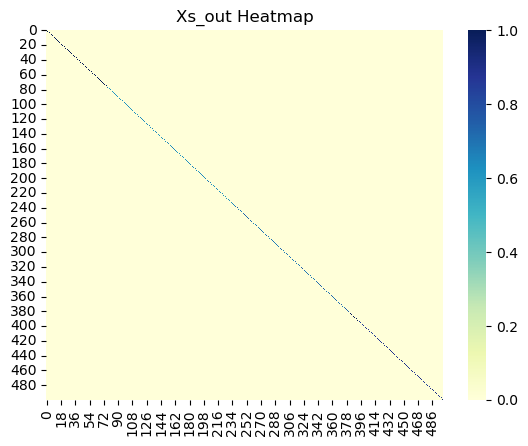

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot a heatmap of the Xs_out matrix

sns.heatmap(Xs, cmap="YlGnBu")
plt.title("Xs_out Heatmap")

plt.show()

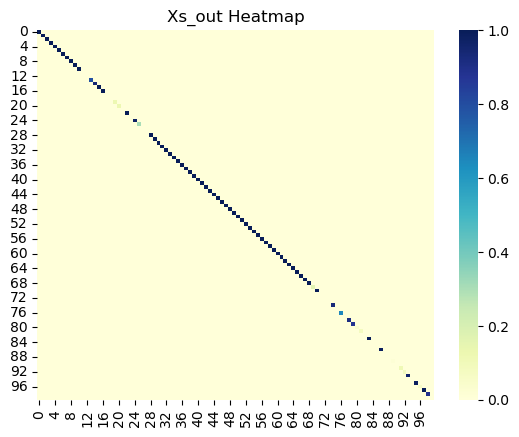

In [52]:
import numpy as np
import scipy.io as sio
Xs_out = sio.loadmat("Xs_out.mat")["Xs_out"]

Xs = vector_to_symmetric(Xs_out, 100)
sns.heatmap(Xs, cmap="YlGnBu")
plt.title("Xs_out Heatmap")

plt.show()